# Trabajo Práctico Final - Grupo 2
## Matías Bergerman, Pablo González Leiro, Tobias Demeco, Matías Tripoli

Set up (Windows cmd)

1. Crear un entorno virtual (recomendado) e instalar las librerías necesarias:

    `python -m venv venv`

    `pip install -r '.\TP final - PCB Defect Detection\requirements.txt'`

2. Bajar el token para la API de Kaggle (https://www.kaggle.com/docs/api). Luego bajar la base de datos (1.88GB):

    `cd "TP final - PCB Defect Detection"`

    `kaggle datasets download -d akhatova/pcb-defects`

    `tar -xf pcb-defects.zip`

    `del pcb-defects.zip`

In [2]:
# Import Libraries

import os
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import pandas as pd
import xml.etree.ElementTree as ET 

## Abrir las anotaciones

In [10]:
path_an = "./PCB_DATASET/Annotations"
print(path_an)

./PCB_DATASET/Annotations


In [4]:
dataset = {
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "class":[],    
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path_an):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))

# print(all_files)       
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [5]:
for annotation in all_files:
    # print(anno)
    tree = ET.parse(annotation)
    
    for elem in tree.iter():
        # print(elem)
        
        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                
                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['class']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]         

In [6]:
data=pd.DataFrame(dataset)
data

Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, class, file, width, height]
Index: []

## Visualización

In [7]:
def display_np(x, scale = 1.0, resampling = Image.Resampling.BICUBIC):
    im = Image.fromarray(x.clip(0, 255).astype(np.uint8))
    display(im.resize((np.array(im.size)*scale).astype(int), resampling))
    
def display_np_row(x, scale = 1.0, resampling = Image.Resampling.BICUBIC, spacer_width = 0, spacer_grayscale = 0):
    img = np.array(x, dtype=np.uint8)
    if len(img.shape) <= 3:
        spacer = np.ones((img[0].shape[0], spacer_width), dtype=np.uint8) * spacer_grayscale
    else:
        spacer = np.ones((img[0].shape[0], spacer_width, img[0].shape[2]), dtype=np.uint8) * spacer_grayscale
        
    img_combined = img[0]
    for i in range(1, len(img)):
        img_combined = np.concatenate((img_combined, spacer, img[i]), axis=1)
    display_np(img_combined, scale, resampling)

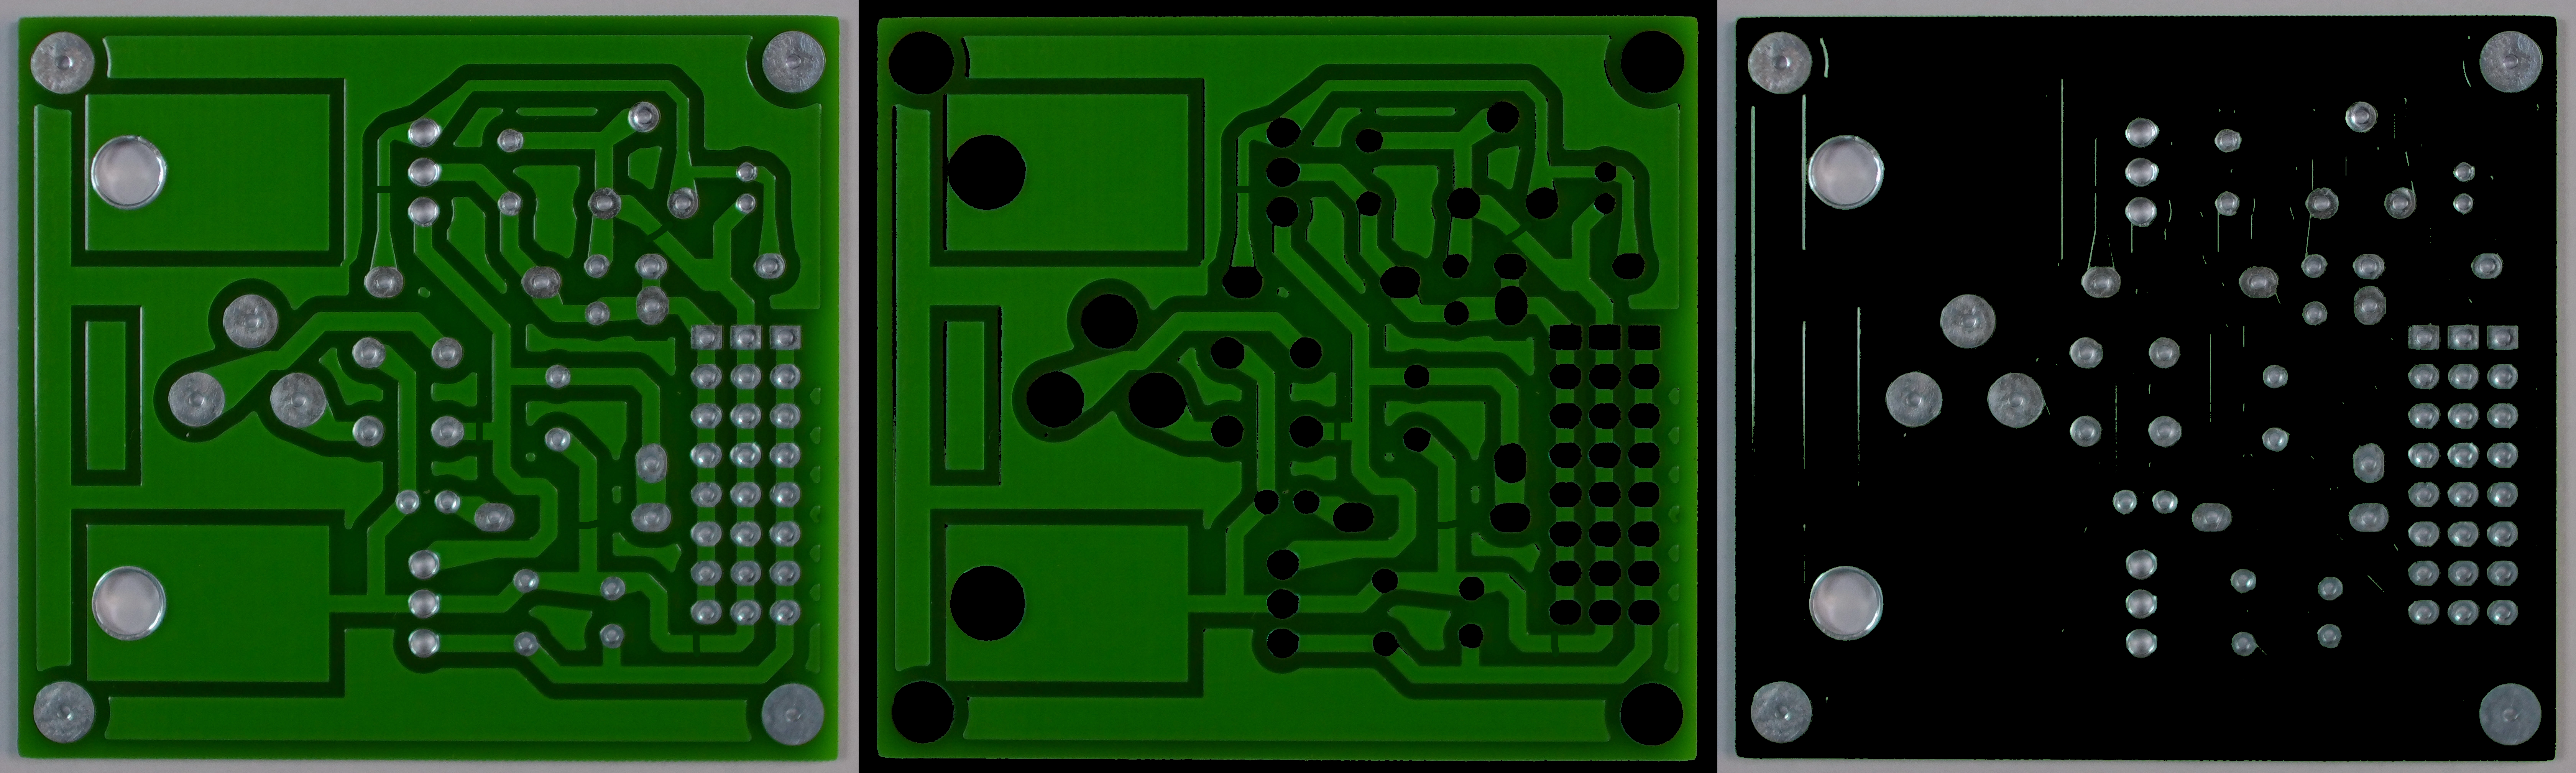

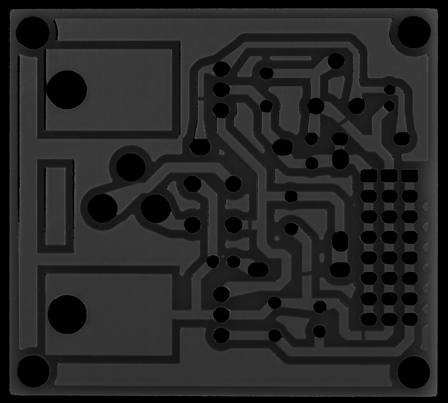

In [9]:
path_used ="./PCB_DATASET/PCB_USED/"
path_db ="./PCB_DATASET/images/"

img_pcb = cv2.imread(path_db+'Open_circuit/10_open_circuit_01.jpg')
hsv_pcb =  cv2.cvtColor(img_pcb, cv2.COLOR_RGB2HSV)

light_green = (30, 120, 0)
dark_green = (80, 255, 255)

mask_silk = cv2.inRange(hsv_pcb, light_green, dark_green)
mask_pad = cv2.inRange(hsv_pcb, light_green, dark_green)
pcb_silk = cv2.bitwise_and(img_pcb, img_pcb, mask=mask_silk)
pcb_pad = cv2.bitwise_and(img_pcb, img_pcb, mask=cv2.bitwise_not(mask_pad))

pcb_silk_gray = cv2.cvtColor(pcb_silk, cv2.COLOR_BGR2GRAY)

display_np_row([img_pcb, pcb_silk, pcb_pad])
display_np(pcb_silk_gray, 0.2)

In [11]:
def img_histogram(x, ignore_black = False):
    y = np.zeros(256)
    for val in x.flatten().astype(np.uint8):
        y[val] += 1
    if ignore_black:
        result = [0] + y[1:] 
        result /= np.size(x) - y[0]
    else:
        result = y / np.size(x)
    return result

def equalize_histogram(x, ignore_black = False):
    hsum = np.cumsum(img_histogram(x, ignore_black))
    map_level = np.vectorize(lambda p: hsum[p]*255)
    return np.clip(map_level(x), 0, 255).astype(np.uint8)

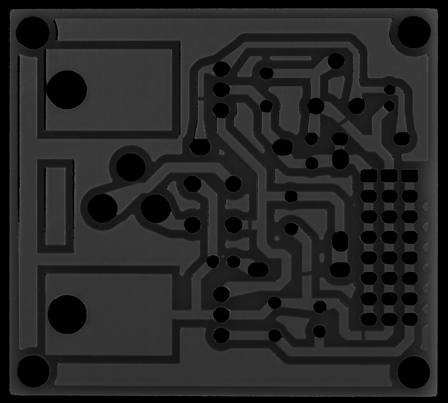

NameError: name 'x' is not defined

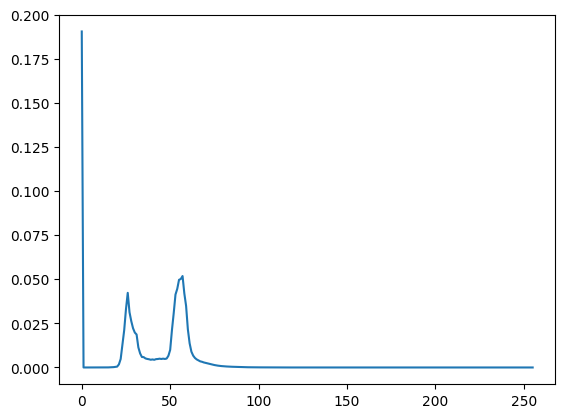

In [12]:
display_np(pcb_silk_gray, 0.2)

hist = img_histogram(pcb_silk_gray)

plt.plot(hist)
peaks,_ = find_peaks(hist, distance = 5, prominence = 0.01)
plt.plot(x, [hist[i] for i in x], 'o')
plt.show()

In [ ]:
pcb_binary = cv2.threshold(pcb_silk_gray, (peaks[0]+peaks[1])/2, 255, cv2.THRESH_BINARY)[1]

kernel = np.ones((3, 3), dtype=np.uint8)
img_eroded  = cv2.erode(pcb_binary, kernel)


kernel = np.ones((25, 25), dtype=np.uint8)
img2  = cv2.dilate(img_eroded, kernel)
img2  = cv2.erode(img2, kernel)

kernel = np.ones((10, 10), dtype=np.uint8)
img3  = cv2.erode(img2-img_eroded, kernel)
kernel = np.ones((20, 20), dtype=np.uint8)
img3  = cv2.dilate(img3, kernel)

display_np_row([pcb_binary, img_eroded, img2, img3], 0.25)

: 